In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rn
import tensorflow as tf
import keras
import warnings

from scipy.io import loadmat
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/mnist-original/mnist-original.mat


In [2]:
%config IPCompleter.greedy = True

In [3]:
warnings.filterwarnings('ignore')

tf.set_random_seed(30)

### 1. Load Dataset

In [4]:
mnist = loadmat('../input/mnist-original/mnist-original.mat')

In [5]:
x = mnist['data'].T
y = mnist['label'][0]

In [6]:
print('MNIST data shape - {0}'.format(x.shape))
print('MNIST label shape - {0}'.format(y.shape))

MNIST data shape - (70000, 784)
MNIST label shape - (70000,)


### 2. Data Preparation

In [7]:
img_height = 28
img_width = 28
channels = 1

input_shape = (img_height, img_width, channels)
num_classes = 10

epoch = 20
batch_size = 128

transform input image array into a compatible shape : (total images, image height, image width, number of channels)

* spatial dimension of each image : 28 X 28
* number of channels : 1 (gray scale)

In [8]:
x_reshape = x.reshape(x.shape[0], img_height, img_width, channels)

print(x_reshape.shape)

(70000, 28, 28, 1)


convert output labels into one-hot encoded vectors

In [9]:
y_encoded = keras.utils.to_categorical(y, num_classes)

print(y_encoded.shape)

(70000, 10)


display one-hot encoded 'label' vectors of 10 random images

In [10]:
idx = rn.sample(range(0, len(y_encoded)), 10)
y_random = []
for i in idx:
    y_random.append([int(x) for x in y_encoded[i]])

y_random

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

* each pixel value should be *float* type
* since all are *gray scale* images, normalize by dividing with 255

In [11]:
x_reshape = x_reshape.astype('float32')
x_reshape /= 255

### 3. Train / Test Split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_reshape, y_encoded, test_size = 0.25, random_state = 0)

In [13]:
print('training data shape : image - {0}, label - {1}'.format(x_train.shape, y_train.shape))
print('test data shape : image - {0}, label - {1}'.format(x_test.shape, y_test.shape))

training data shape : image - (52500, 28, 28, 1), label - (52500, 10)
test data shape : image - (17500, 28, 28, 1), label - (17500, 10)


display a random image from training dataset

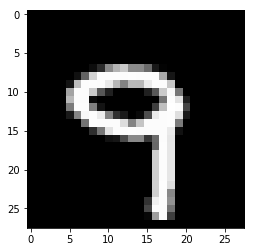

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

idx = rn.randint(0, x_train.shape[0])
plt.imshow(x_train[idx][:,:,0],"gray") 

split training dataset further into train and validation

In [15]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)

In [16]:
print('training data shape : image - {0}, label - {1}'.format(x_train.shape, y_train.shape))
print('validation data shape : image - {0}, label - {1}'.format(x_validation.shape, y_validation.shape))

training data shape : image - (39375, 28, 28, 1), label - (39375, 10)
validation data shape : image - (13125, 28, 28, 1), label - (13125, 10)


### 4. Model Definition

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [18]:
# model
model = Sequential()

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

### 5. Model Compile

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### 6. Model Training

In [20]:
model.fit(x_train, 
         y_train,
         batch_size = batch_size,
         epochs = epoch,
         verbose = 1,
         validation_data=(x_validation, y_validation))

Train on 39375 samples, validate on 13125 samples
Epoch 1/20
39375/39375 [==============================] - 6s 149us/step - loss: 0.3394 - accuracy: 0.8936 - val_loss: 0.0947 - val_accuracy: 0.9708
Epoch 2/20
39375/39375 [==============================] - 2s 60us/step - loss: 0.1132 - accuracy: 0.9658 - val_loss: 0.0676 - val_accuracy: 0.9789
Epoch 3/20
39375/39375 [==============================] - 2s 61us/step - loss: 0.0811 - accuracy: 0.9758 - val_loss: 0.0553 - val_accuracy: 0.9829
Epoch 4/20
39375/39375 [==============================] - 2s 61us/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.0521 - val_accuracy: 0.9836
Epoch 5/20
39375/39375 [==============================] - 2s 60us/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.0458 - val_accuracy: 0.9867
Epoch 6/20
39375/39375 [==============================] - 2s 61us/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0557 - val_accuracy: 0.9841
Epoch 7/20
39375/39375 [==============================] - 2s 60us/s

### 7. Model Evaluation

In [21]:
model.evaluate(x_test, y_test)

17500/17500 [==============================] - 1s 64us/step


[0.0384097837367095, 0.9890857338905334]

In [22]:
print(model.metrics_names)

['loss', 'accuracy']


### 8. Change Optimizer

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

### 9. Model Training & Evaluate

In [24]:
model.fit(x_train, 
         y_train,
         batch_size = batch_size,
         epochs = epoch,
         verbose = 1,
         validation_data=(x_validation, y_validation))

Train on 39375 samples, validate on 13125 samples
Epoch 1/20
39375/39375 [==============================] - 2s 61us/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0448 - val_accuracy: 0.9895
Epoch 2/20
39375/39375 [==============================] - 2s 55us/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0446 - val_accuracy: 0.9896
Epoch 3/20
39375/39375 [==============================] - 2s 56us/step - loss: 0.0154 - accuracy: 0.9951 - val_loss: 0.0448 - val_accuracy: 0.9895
Epoch 4/20
39375/39375 [==============================] - 2s 56us/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0448 - val_accuracy: 0.9897
Epoch 5/20
39375/39375 [==============================] - 2s 55us/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0447 - val_accuracy: 0.9896
Epoch 6/20
39375/39375 [==============================] - 2s 56us/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0448 - val_accuracy: 0.9896
Epoch 7/20
39375/39375 [==============================] - 2s 56us/st

In [25]:
model.evaluate(x_test, y_test)

17500/17500 [==============================] - 1s 63us/step


[0.03753949086698745, 0.9904000163078308]

#### *marginal improvement on change of optimizer from Adadelta to SGD*